In [8]:
import pygame
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats

In [9]:
from enum import Enum
from collections import namedtuple

class Movement(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Coordinate = namedtuple("Coordinate", "x, y")

# Инициализация Pygame
pygame.display.init()
pygame.font.init()

font = pygame.font.Font(pygame.font.get_default_font(), 25)

# RGB цвета
COLOR_WHITE = (255, 255, 255)
COLOR_RED = (200, 0, 0)
COLOR_GREEN = (0, 255, 0)
COLOR_LIGHT_GREEN = (153, 255, 153)
COLOR_BLACK = (0, 0, 0)

BLOCK_DIMENSION = 20
GAME_SPEED = 120

class SnakeGame:

    def __init__(self, width=640, height=480):
        self.width = width
        self.height = height

        # Инициализация дисплея
        self.display = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Snake Game")
        self.clock = pygame.time.Clock()

        # Инициализация игры
        self.restart()

    def restart(self):
        self.direction = Movement.RIGHT
        self.head_position = Coordinate(self.width / 2, self.height / 2)
        self.snake_body = [self.head_position,
                           Coordinate(self.head_position.x - BLOCK_DIMENSION, self.head_position.y),
                           Coordinate(self.head_position.x - (2 * BLOCK_DIMENSION), self.head_position.y)]

        self.score = 0
        self.food_position = None

        self.spawn_food()

        self.frame_count = 0

    def spawn_food(self):
        x = random.randint(0, (self.width - BLOCK_DIMENSION) // BLOCK_DIMENSION) * BLOCK_DIMENSION
        y = random.randint(0, (self.height - BLOCK_DIMENSION) // BLOCK_DIMENSION) * BLOCK_DIMENSION
        self.food_position = Coordinate(x, y)
        if self.food_position in self.snake_body:
            self.spawn_food()

    def play_turn(self, action):
        # Увеличиваем количество кадров
        self.frame_count += 1

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()

            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q:
                    pygame.quit()
                    return

        # Перемещаем змею
        self.move_snake(action)

        reward = 0

        # Проверяем окончание игры
        if self.check_collision() or self.frame_count > 100 * len(self.snake_body):
            game_over = True
            reward -= 10
            return reward, game_over, self.score, self.frame_count

        # Перемещение змеи или размещение еды
        if self.head_position == self.food_position:
            self.score += 1
            reward = 10
            self.spawn_food()
        else:
            self.snake_body.pop()

        # Обновляем интерфейс и время
        self.update_display()
        self.clock.tick(GAME_SPEED)

        game_over = False

        return reward, game_over, self.score, self.frame_count

    def check_collision(self, point: Coordinate = None):
        if point is None:
            point = self.head_position

        # Проверка на столкновение со стенами
        if point.x > self.width - BLOCK_DIMENSION or point.x < 0:
            return True

        if point.y > self.height - BLOCK_DIMENSION or point.y < 0:
            return True

        # Проверка на столкновение с телом змеи
        if point in self.snake_body[1:]:
            return True

        return False

    def move_snake(self, action):
        # Определение направлений
        direction_sequence = [Movement.RIGHT, Movement.DOWN, Movement.LEFT, Movement.UP]
        current_index = direction_sequence.index(self.direction)

        new_direction = self.direction

        if np.array_equal(action, [0, 1, 0]):
            new_direction = direction_sequence[(current_index + 1) % 4]
        elif np.array_equal(action, [0, -1, 0]):
            new_direction = direction_sequence[(current_index - 1) % 4]

        self.direction = new_direction

        x = self.head_position.x
        y = self.head_position.y

        if self.direction == Movement.RIGHT:
            x += BLOCK_DIMENSION
        elif self.direction == Movement.LEFT:
            x -= BLOCK_DIMENSION
        elif self.direction == Movement.UP:
            y -= BLOCK_DIMENSION
        elif self.direction == Movement.DOWN:
            y += BLOCK_DIMENSION

        self.head_position = Coordinate(x, y)
        self.snake_body.insert(0, self.head_position)

    def update_display(self):
        self.display.fill(COLOR_BLACK)

        for p in self.snake_body:
            pygame.draw.rect(self.display, COLOR_GREEN, pygame.Rect(p.x, p.y, BLOCK_DIMENSION, BLOCK_DIMENSION))
            pygame.draw.rect(self.display, COLOR_LIGHT_GREEN, pygame.Rect(p.x + 4, p.y + 4, 12, 12))

        pygame.draw.rect(self.display, COLOR_RED, pygame.Rect(self.food_position.x, self.food_position.y, BLOCK_DIMENSION, BLOCK_DIMENSION))

        scoreText = font.render("Score: " + str(self.score) + " ; " + self.playerName + ' ; Q - выйти', True, COLOR_WHITE)

        self.display.blit(scoreText, [0, 0])

        pygame.display.flip()


    def setPlayerName(self, name):
        self.playerName = name

In [10]:
class GameAgent:   
    def __init__(self):   
        self.games_played = 0   
         
    def select_action(self):  
        # Генерируем случайное действие из трех возможных направлений
        action = random.choice([0, 1, 2])  # Предполагается, что 0 - влево, 1 - вправо, 2 - вверх/вниз
        final_move = [0, 0, 0]

        final_move[action] = 1  
        return final_move


In [11]:
scoresHistory = []  
meanScores = []  
stepsToEndGame = []  # Список для хранения шагов до окончания игры
stepsToFirstApple = []  # Список для хранения шагов до съедения первого яблока

def train():  
    totalScore = 0  
    bestScore = 0  
 
    agent = GameAgent()  
    game = SnakeGame()  
 
    # мы тренируем модель на 200 играх  
    while agent.games_played < 200:  
        game.setPlayerName("Игра #" + str(agent.games_played))    
 
        steps = 0  # Счетчик шагов
        firstAppleEaten = False  # Флаг для отслеживания съедения первого яблока

        # движение (выбор действия случайным образом) 
        finalMove = agent.select_action()  
 
        # выполняем движение и получаем новое состояние  
        reward, done, score, steps = game.play_turn(finalMove)   

        # Проверяем, съедена ли яблоко
        if reward > 0 and not firstAppleEaten:
            stepsToFirstApple.append(steps)
            firstAppleEaten = True 

        if done:  
            stepsToEndGame.append(steps)  # Сохраняем количество шагов до окончания игры

            # сбрасываем игру  
            game.restart()  
            agent.games_played += 1  

            if score > bestScore:  
                bestScore = score  
 
            totalScore += score  
            meanScore = (totalScore / agent.games_played)  
 
            scoresHistory.append(score)  
            meanScores.append(meanScore)  
 
            if score == bestScore or agent.games_played % 10 == 0:  
                print("Game number: ", agent.games_played, "Score: ", score, "Best Score: ", bestScore, "Mean scores: ", meanScore)  

# запускаем метод тренировки
try:               
    train()
except TypeError:
    print('Игра завершилась досрочно (cannot unpack non-iterable NoneType object)')




Game number:  1 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  2 Score:  1 Best Score:  1 Mean scores:  0.5
Игра завершилась досрочно (cannot unpack non-iterable NoneType object)


In [12]:

# Функция для вычисления и вывода статистики
def print_statistics(steps_list, description):
    if steps_list:
        print(f"{description}:")
        print(f"Min: {np.min(steps_list)}")
        print(f"Max: {np.max(steps_list)}")
        print(f"Mean: {np.mean(steps_list)}")
        print(f"Mode: {stats.mode(steps_list)[0]}")
        print(f"Median: {np.median(steps_list)}")
        print(f"Standard Deviation: {np.std(steps_list)}")
    else:
        print(f"No data for {description}.")

# Печатаем статистику
print_statistics(stepsToEndGame, "Steps to End Game")
print('-' * 10)
print_statistics(stepsToFirstApple, "Steps to First Apple")


Steps to End Game:
Min: 71
Max: 241
Mean: 131.0
Mode: 71
Median: 81.0
Standard Deviation: 77.88880963698615
----------
Steps to First Apple:
Min: 76
Max: 76
Mean: 76.0
Mode: 76
Median: 76.0
Standard Deviation: 0.0


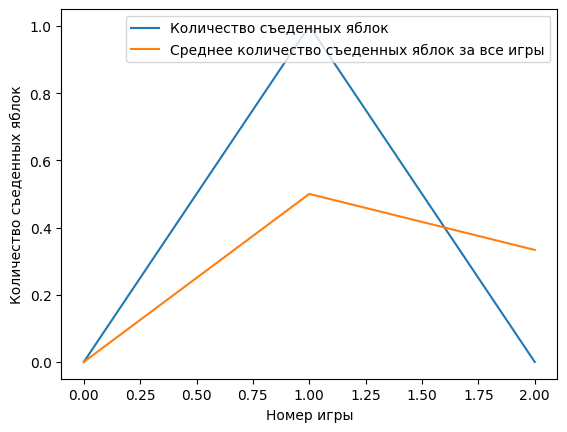

In [15]:
plt.plot(scoresHistory)
plt.ylabel('Количество съеденных яблок')
plt.xlabel('Номер игры')
plt.plot(meanScores)
plt.legend(["Количество съеденных яблок", "Среднее количество съеденных яблок за все игры"])